In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


# Building the model

Text(0.5, 1.0, 'Shape: (32, 32, 3)')

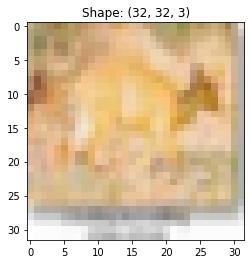

In [2]:
# load data and split it into Test, train and validation sets

(X_1, y_1), (X_2, y_2) = tf.keras.datasets.cifar10.load_data()
X = np.vstack((X_1, X_2))
y = np.vstack((y_1, y_2))
X_train, X, y_train, y = train_test_split(X, y, train_size=0.8, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5, stratify=y)

assert X_test.shape == X_valid.shape, 'X_test and X_valid have different shapes'
for i in range(10):
    assert np.count_nonzero(keras.utils.to_categorical(y_train)[:, i]) == 4800 , 'Sample is not stratified'
sample_shape = X_train[0].shape
plt.imshow(X_train[1])
plt.title(f'Shape: {sample_shape}')

In [3]:
# normalize the data
# it would be better to use keras.utils.normalize for this, but then it would be impossible to de-normalize the data

X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

In [6]:
# build the model

model = Sequential()
model.add(Input(shape=sample_shape))
model.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model.add(UpSampling2D())
model.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 12)       

In [7]:
# train the model
history = model.fit(X_train, X_train, validation_data=(X_valid, X_valid), epochs=10, verbose=1, use_multiprocessing=True)

2021-11-04 20:34:52.752972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.0118 - mean_absolute_error: 0.0738 - cosine_similarity: 0.9839 - val_loss: 0.0064 - val_mean_absolute_error: 0.0572 - val_cosine_similarity: 0.9896
Epoch 2/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.0058 - mean_absolute_error: 0.0543 - cosine_similarity: 0.9906 - val_loss: 0.0054 - val_mean_absolute_error: 0.0521 - val_cosine_similarity: 0.9903
Epoch 3/10
1500/1500 [==============================] - 51s 34ms/step - loss: 0.0051 - mean_absolute_error: 0.0508 - cosine_similarity: 0.9910 - val_loss: 0.0050 - val_mean_absolute_error: 0.0505 - val_cosine_similarity: 0.9909
Epoch 4/10
1500/1500 [==============================] - 50s 34ms/step - loss: 0.0048 - mean_absolute_error: 0.0489 - cosine_similarity: 0.9913 - val_loss: 0.0047 - val_mean_absolute_error: 0.0481 - val_cosine_similarity: 0.9905
Epoch 5/10
1500/1500 [==============================] - 53s 35ms/step - loss: 0.0045 - m

In [8]:
model.evaluate(X_train, X_train)


1500/1500 [==============================] - 14s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0441 - cosine_similarity: 0.9917


[0.00394122488796711, 0.044128526002168655, 0.991692304611206]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


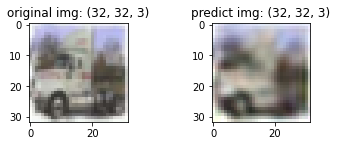

In [9]:
def plot_img_compare(model, data, img_nr):
    """Plot original image next to predicted image 

    Args:
        model (model accepting.predict() method): the model to predict
        data (np.array): the whole data stack
        img_nr (int): the index of to use for image plot.
    """
    assert type(img_nr) == int, 'wrong dtype for img_nr'
    predictions = model.predict(data)
    pred_img = predictions[img_nr]
    plt.subplot(221).imshow(data[img_nr])
    plt.subplot(221).set_title(f'original img: {data[img_nr].shape}')
    plt.subplot(222).imshow(pred_img)
    plt.subplot(222).set_title(f'predict img: {predictions[img_nr].shape}')
    plt.show()
# plot_img_compare(model, X_train[0])

plot_img_compare(model, X_test, 1)

In [ ]:
# load a pretrained model

def load_model(path = 'models/CAE'):
    return keras.models.load_model(path)


pretrained_model = load_model()